<a href="https://colab.research.google.com/github/binliu0630/Deep_Learning/blob/master/Classification_with_Fastai_for_Tabular_with_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [85]:
from fastai.tabular import *
from fastai.text import *
from fastai.text.data import _join_texts

print(f'fastai version: {__version__}')

fastai version: 1.0.59


In [11]:
# device = torch.cuda.current_device()
# print(device)
# torch.cuda.set_device(device)

0


Custom DatablockAPI

In [0]:
class MixedTabularLine(TabularLine):
    "Item's that include both tabular data(`conts` and `cats`) and textual data (numericalized `ids`)"
    
    def __init__(self, cats, conts, cat_classes, col_names, txt_ids, txt_cols, txt_string):
        # tabular
        super().__init__(cats, conts, cat_classes, col_names)

        # add the text bits
        self.text_ids = txt_ids
        self.text_cols = txt_cols
        self.text = txt_string
        
        # append numericalted text data to your input (represents your X values that are fed into your model)
        # self.data = [tensor(cats), tensor(conts), tensor(txt_ids)]
        self.data += [ np.array(txt_ids, dtype=np.int64) ]
        self.obj = self.data
        
    def __str__(self):
        res = super().__str__() + f'Text: {self.text}'
        return res

In [0]:
class MixedTabularProcessor(TabularProcessor):
    
    def __init__(self, ds:ItemList=None, procs=None, 
                 tokenizer:Tokenizer=None, chunksize:int=10000,
                 vocab:Vocab=None, max_vocab:int=60000, min_freq:int=2):
        #pdb.set_trace()
        super().__init__(ds, procs)
    
        self.tokenizer, self.chunksize = ifnone(tokenizer, Tokenizer()), chunksize
        
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab, self.max_vocab, self.min_freq = vocab, max_vocab, min_freq
        
    # process a single item in a dataset
    # NOTE: THIS IS METHOD HAS NOT BEEN TESTED AT THIS POINT (WILL COVER IN A FUTURE ARTICLE)
    def process_one(self, item):
        # process tabular data (copied form tabular.data)
        df = pd.DataFrame([item, item])
        for proc in self.procs: proc(df, test=True)
            
        if len(self.cat_names) != 0:
            codes = np.stack([c.cat.codes.values for n,c in df[self.cat_names].items()], 1).astype(np.int64) + 1
        else: 
            codes = [[]]
            
        if len(self.cont_names) != 0:
            conts = np.stack([c.astype('float32').values for n,c in df[self.cont_names].items()], 1)
        else: 
            conts = [[]]
            
        classes = None
        col_names = list(df[self.cat_names].columns.values) + list(df[self.cont_names].columns.values)
        
        # process textual data
        if len(self.text_cols) != 0:
            txt = _join_texts(df[self.text_cols].values, (len(self.text_cols) > 1))
            txt_toks = self.tokenizer._process_all_1(txt)[0]
            text_ids = np.array(self.vocab.numericalize(txt_toks), dtype=np.int64)
        else:
            txt_toks, text_ids = None, [[]]
            
        # return ItemBase
        return MixedTabularLine(codes[0], conts[0], classes, col_names, text_ids, self.txt_cols, txt_toks)
    
    # processes the entire dataset
    def process(self, ds):
        #pdb.set_trace()
        # process tabular data and then set "preprocessed=False" since we still have text data possibly
        super().process(ds)
        ds.preprocessed = False
        
        # process text data from column(s) containing text
        if len(ds.text_cols) != 0:
            texts = _join_texts(ds.inner_df[ds.text_cols].values, (len(ds.text_cols) > 1))

            # tokenize (set = .text)
            tokens = []
            for i in progress_bar(range(0, len(ds), self.chunksize), leave=False):
                tokens += self.tokenizer.process_all(texts[i:i+self.chunksize])
            ds.text = tokens

            # set/build vocab
            if self.vocab is None: self.vocab = Vocab.create(ds.text, self.max_vocab, self.min_freq)
            ds.vocab = self.vocab
            ds.text_ids = [ np.array(self.vocab.numericalize(toks), dtype=np.int64) for toks in ds.text ]
        else:
            ds.text, ds.vocab, ds.text_ids = None, None, []
            
        ds.preprocessed = True

In [0]:
# similar to the "fasta.text.data.pad_collate" except that it is designed to work with MixedTabularLine items,
# where the final thing in an item is the numericalized text ids.
# we need a collate function to ensure a square matrix with the text ids, which will be of variable length.
def mixed_tabular_pad_collate(samples:BatchSamples, 
                              pad_idx:int=1, pad_first:bool=True) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding."

    samples = to_data(samples)
    max_len = max([len(s[0][-1]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
   
    for i,s in enumerate(samples):
        if pad_first: 
            res[i,-len(s[0][-1]):] = LongTensor(s[0][-1])
        else:         
            res[i,:len(s[0][-1]):] = LongTensor(s[0][-1])
            
        # replace the text_ids array (the last thing in the inputs) with the padded tensor matrix
        s[0][-1] = res[i]
             
    # 10/31/2019 (wtg) - keeping the old code so you can see the difference ...
    # for the inputs, return a list containing 3 elements: a list of cats, a list of conts, and a list of text_ids
    # return [x for x in zip(*[s[0] for s in samples])], tensor([s[1] for s in samples])

    cats = torch.cat([ s[0][0].unsqueeze(0) for s in samples ], 0)
    conts = torch.cat([ s[0][1].unsqueeze(0) for s in samples ], 0)
    texts = torch.cat([ s[0][2].unsqueeze(0) for s in samples ], 0)
    return [cats, conts, texts], tensor([ s[1] for s in samples ])

In [0]:
# each "ds" is of type LabelList(Dataset)
class MixedTabularDataBunch(DataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs=64, 
               pad_idx=1, pad_first=True, no_check:bool=False, **kwargs) -> DataBunch:
        
        # only thing we're doing here is setting the collate_fn = to our new "pad_collate" method above
        collate_fn = partial(mixed_tabular_pad_collate, pad_idx=pad_idx, pad_first=pad_first)
        
        kwargs['collate_fn'] = collate_fn
        kwargs['num_workers'] = 1
        return super().create(train_ds, valid_ds, test_ds, path=path, bs=bs, no_check=no_check, **kwargs)

In [0]:
class MixedTabularList(TabularList):
    "A custom `ItemList` that merges tabular data along with textual data"
    
    _item_cls = MixedTabularLine
    _processor = MixedTabularProcessor
    _bunch = MixedTabularDataBunch
    
    def __init__(self, items:Iterator, cat_names:OptStrList=None, cont_names:OptStrList=None, 
                 text_cols=None, vocab:Vocab=None, pad_idx:int=1, 
                 procs=None, **kwargs) -> 'MixedTabularList':
        #pdb.set_trace()
        super().__init__(items, cat_names, cont_names, procs, **kwargs)
        
        self.cols = [] if cat_names == None else cat_names.copy()
        if cont_names: self.cols += cont_names.copy()
        if txt_cols: self.cols += text_cols.copy()
        
        self.text_cols, self.vocab, self.pad_idx = text_cols, vocab, pad_idx
        
        # add any ItemList state into "copy_new" that needs to be copied each time "new()" is called; 
        # your ItemList acts as a prototype for training, validation, and/or test ItemList instances that
        # are created via ItemList.new()
        self.copy_new += ['text_cols', 'vocab', 'pad_idx']
        
        self.preprocessed = False
        
    # defines how to construct an ItemBase from the data in the ItemList.items array
    def get(self, i):
        if not self.preprocessed: 
            return self.inner_df.iloc[i][self.cols] if hasattr(self, 'inner_df') else self.items[i]
        
        codes = [] if self.codes is None else self.codes[i]
        conts = [] if self.conts is None else self.conts[i]
        text_ids = [] if self.text_ids is None else self.text_ids[i]
        text_string = None if self.text_ids is None else self.vocab.textify(self.text_ids[i])
        
        return self._item_cls(codes, conts, self.classes, self.col_names, text_ids, self.text_cols, text_string)
    
    # this is the method that is called in data.show_batch(), learn.predict() or learn.show_results() 
    # to transform a pytorch tensor back in an ItemBase. 
    # in a way, it does the opposite of calling ItemBase.data. It should take a tensor t and return 
    # the same king of thing as the get method.
    def reconstruct(self, t:Tensor):
        return self._item_cls(t[0], t[1], self.classes, self.col_names, 
                              t[2], self.text_cols, self.vocab.textify(t[2]))
    
    # tells fastai how to display a custom ItemBase when data.show_batch() is called
    def show_xys(self, xs, ys) -> None:
        "Show the `xs` (inputs) and `ys` (targets)."
        from IPython.display import display, HTML
        
        # show tabular
        display(HTML('TABULAR:<br>'))
        super().show_xys(xs, ys)
        
        # show text
        items = [['text_data', 'target']]
        for i, (x,y) in enumerate(zip(xs,ys)):
            res = []
            res += [' '.join([ f'{tok}({self.vocab.stoi[tok]})' 
                              for tok in x.text.split() if (not self.vocab.stoi[tok] == self.pad_idx) ])]
                
            res += [str(y)]
            items.append(res)
            
        col_widths = [90, 1]
        
        display(HTML('TEXT:<br>'))
        display(HTML(text2html_table(items)))
        
    # tells fastai how to display a custom ItemBase when learn.show_results() is called
    def show_xyzs(self, xs, ys, zs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions)."
        from IPython.display import display, HTML
        
        # show tabular
        super().show_xyzs(xs, ys, zs)
        
        # show text
        items = [['text_data','target', 'prediction']]
        for i, (x,y,z) in enumerate(zip(xs,ys,zs)):
            res = []
            res += [' '.join([ f'{tok}({self.vocab.stoi[tok]})'
                              for tok in x.text.split() if (not self.vocab.stoi[tok] == self.pad_idx) ])]
                
            res += [str(y),str(z)]
            items.append(res)
            
        col_widths = [90, 1, 1]
        display(HTML('<br>' + text2html_table(items)))
    
        
    @classmethod
    def from_df(cls, df:DataFrame, cat_names:OptStrList=None, cont_names:OptStrList=None, 
                text_cols=None, vocab=None, procs=None, **kwargs) -> 'ItemList':
        
        return cls(items=range(len(df)), cat_names=cat_names, cont_names=cont_names, 
                   text_cols=text_cols, vocab=vocab, procs=procs, inner_df=df, **kwargs)
    
    

**Dataset**

In [0]:
data = pd.read_csv("https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv")

In [84]:
data.head()

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
2,B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1310601600,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"
3,B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1316131200,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)<br /><br />They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats."
4,B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1334793600,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.


In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Score,100000.0,4.186090e+00,1.309541e+00,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
HelpfulnessDenominator,100000.0,2.236560e+00,8.805400e+00,0.0,0.000000e+00,1.000000e+00,2.000000e+00,8.780000e+02
Id,100000.0,2.846200e+05,1.641594e+05,3.0,1.422378e+05,2.856740e+05,4.263818e+05,5.684360e+05
HelpfulnessNumerator,100000.0,1.745550e+00,8.171451e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,8.660000e+02
Time,100000.0,1.296172e+09,4.810743e+07,940809600.0,1.271203e+09,1.311120e+09,1.332720e+09,1.351210e+09


In [20]:
data.columns

Index(['ProductId', 'UserId', 'Summary', 'Score', 'HelpfulnessDenominator',
       'Id', 'ProfileName', 'HelpfulnessNumerator', 'Time', 'Text'],
      dtype='object')

In [0]:
cat_cols = ['ProductId', 'UserId', 'Id', 'ProfileName']
cont_cols = ['HelpfulnessDenominator', 'HelpfulnessNumerator']
txt_cols = ['Summary','Text']
dep_var = ['Score']

procs = [FillMissing, Categorify, Normalize]

In [0]:
il = MixedTabularList.from_df(data, cat_cols, cont_cols, txt_cols, vocab=None, procs=procs)

In [26]:
il.get(0)

ProductId                                                        B00141QYSQ
UserId                                                       A1YS02UZZGRDCT
Id                                                                    41471
ProfileName                                                  Evan Eberhardt
HelpfulnessDenominator                                                    2
HelpfulnessNumerator                                                      2
Summary                                                          Do Not Buy
Text                      These are made in China (do not buy ANY pet fo...
Name: 0, dtype: object

In [0]:
ils = il.split_by_rand_pct(valid_pct=0.2, seed=1234)

In [28]:
len(ils.train), len(ils.valid)

(80000, 20000)

In [0]:
ll = ils.label_from_df(dep_var)

In [32]:
type(ll), type(ll.train), len(ll.lists)

(fastai.data_block.LabelLists, fastai.data_block.LabelList, 2)

In [33]:
ll.train

LabelList (80000 items)
x: MixedTabularList
ProductId B0089SPEO2; UserId A3JOYNYL458QHP; Id 28582; ProfileName coleridge; HelpfulnessDenominator -0.2631; HelpfulnessNumerator -0.2219; Text: xxbos xxfld 1 xxmaj less lemon and less zing xxfld 2 xxmaj everything is ok , except it just is n't as good as it is in the bags . xxmaj just considerably more bland -- less lemon and less zing . xxmaj boring .,ProductId B001PMCDK2; UserId A14TTMM0Z03Y2W; Id 389965; ProfileName Lindsay S. Bradford; HelpfulnessDenominator -0.2631; HelpfulnessNumerator -0.2219; Text: xxbos xxfld 1 my cat goes crazy for these ! xxfld 2 xxmaj best cat treat ever . xxmaj there is n't anything comparable to the love my cat has for these treats , he snubs away any other kind now . 
  i know he likes to manipulate me with his xxunk but these treats are my way of manipulating him to come sit on my lap and have some chill time . :),ProductId B002Q8JOSI; UserId A17UQD2RSSQH5X; Id 212536; ProfileName in the dark; HelpfulnessDen

In [34]:
ll.train.x[0], ll.train.y[0], ll.train.x.codes[0], ll.train.x.cat_names, ll.train.x.text_ids[0]

(MixedTabularLine ProductId B0089SPEO2; UserId A3JOYNYL458QHP; Id 28582; ProfileName coleridge; HelpfulnessDenominator -0.2631; HelpfulnessNumerator -0.2219; Text: xxbos xxfld 1 xxmaj less lemon and less zing xxfld 2 xxmaj everything is ok , except it just is n't as good as it is in the bags . xxmaj just considerably more bland -- less lemon and less zing . xxmaj boring .,
 Category 3,
 array([27527, 40148,  4101, 47130]),
 ['ProductId', 'UserId', 'Id', 'ProfileName'],
 array([   2,    4,   21,    5,  214,  561,   13,  214, 3298,    4,   20,    5,  507,   18,  498,   11,  966,   15,
          58,   18,   37,   38,   43,   38,   15,   18,   24,   10,  254,    9,    5,   58, 3619,   69,  871,  228,
         214,  561,   13,  214, 3298,    9,    5, 2509,    9]))

In [36]:
len(ll.train.x.vocab.itos), len(ll.valid.x.vocab.itos)

(33672, 33672)

In [40]:
data_bunch = ll.databunch(bs=32)
b = data_bunch.one_batch()

len(b), len(b[0]), len(b[0][0]), len(b[0][1]), len(b[0][1]), b[1].shape

(2, 3, 32, 32, 32, torch.Size([32]))

In [39]:
b

([tensor([[ 9526, 34221, 48746,    41],
          [ 1558, 53032, 60835, 38694],
          [12482, 47017, 73692, 43448],
          [ 7961, 51682, 29427, 40177],
          [14947, 23539, 15585, 23329],
          [ 1662, 31652, 73078, 44983],
          [ 3471, 46042, 38739, 42210],
          [ 5653, 46113, 59485, 23926],
          [12280, 32680, 52335, 27032],
          [ 2735,  2080, 28633, 27587],
          [ 8890, 52095, 17450, 35049],
          [ 4079, 30979, 10060,  5888],
          [11964,  5674, 70483, 28117],
          [10318, 38273, 21286, 51996],
          [14114, 26687, 50778, 45122],
          [  830, 59127, 33834, 25461],
          [26646,  8974, 13821, 37184],
          [ 2936,  4043, 72491,  6435],
          [16489, 30586, 26330, 52794],
          [10017, 50819,  3447,  3681],
          [20701, 30699, 31235, 33090],
          [25995, 18146, 12386, 32234],
          [ 8163, 49631, 42994,  1336],
          [21413, 32815, 59720,  1509],
          [10022,  3779,  8309, 46150],


In [41]:
data_bunch.show_batch()

ProductId,UserId,Id,ProfileName,HelpfulnessDenominator,HelpfulnessNumerator,target
B000G82L62,A1WS5M1IQLU14L,64579,Anika M. O.,-0.1452,-0.0943,5
B0026LKJTS,A17WER66R17JEF,339771,Larry Finley,-0.1452,-0.0943,5
B0007ZLRUU,A1IFOESRHYQ4AH,10044,"A. Bradley-Verett ""Amanda Verett""",0.3264,0.4160,5
B00004RBDU,A2AJMN9EDT94B3,343426,Gouverneur Girl,-0.2631,-0.2219,5
B0030VJ9UI,A1P6C8KO9IU4OI,238687,gloriarecycles,-0.1452,-0.0943,5


text_data,target
xxbos(2) xxfld(4) 1(21) love(65) this(19) rice(324) !(23) xxfld(4) 2(20) really(85) good(43) quality(188) grains(1005) !(23) easy(227) to(16) prepare(1323) and(13) i(12) feel(319) that(26) my(25) every(198) meal(439) is(18) definitely(257) elevated(8483) with(30) this(19) as(38) a(14) my(25) carbs(1002) !(23) and(13) what(95) 's(36) best(82) is(18) you(28) can(67) get(81) it(15) for(22) much(91) cheaper(453) because(104) of(17) amazon(101) subscribe(684) &(176) save(432) !(23),5
xxbos(2) xxfld(4) 1(21) xxmaj(5) for(22) xxmaj(5) the(10) xxmaj(5) cat(179) xxfld(4) 2(20) xxmaj(5) my(25) cat(179) has(74) never(194) turned(969) up(84) his(240) nose(1528) at(53) this(19) product(54) .(9) xxmaj(5) he(111) always(207) has(74) his(240) choice(538) at(53) meal(439) time(100) and(13) he(111) eats(848) both(277) the(10) chicken(260) and(13) this(19) product(54) without(203) fail(4085) .(9),5
"xxbos(2) xxfld(4) 1(21) xxmaj(5) the(10) best(82) coffee(51) ever(187) xxfld(4) 2(20) xxmaj(5) there(94) is(18) a(14) reason(577) they(35) serve(929) this(19) coffee(51) at(53) the(10) xxmaj(5) white(435) xxmaj(5) house(446) .(9) xxmaj(5) its(217) the(10) smoothest(4896) ,(11) best(82) coffee(51) ever(187) produced(1780) .(9) xxmaj(5) low(294) acid(888) ,(11) smooth(399) in(24) the(10) mouth(513) ,(11) and(13) it(15) has(74) the(10) most(167) intoxicating(9528) aroma(627) .(9) xxmaj(5) worth(307) the(10) price(99) .(9)",5
xxbos(2) xxfld(4) 1(21) xxmaj(5) flea(6691) xxmaj(5) trap(2599) xxmaj(5) refill(3316) pads(9772) xxfld(4) 2(20) xxmaj(5) these(44) are(33) awesome(427) .(9) i(12) only(90) wish(444) that(26) there(94) were(102) more(69) in(24) the(10) package(288) than(78) 3(184) .(9) xxmaj(5) maybe(420) a(14) 6(304) pack(252) or(56) more(69) for(22) the(10) same(212) amount(351) or(56) a(14) few(202) dollars(1332) more(69) !(23) !(23) !(23),5
"xxbos(2) xxfld(4) 1(21) xxmaj(5) good(43) xxmaj(5) snacks(583) xxfld(4) 2(20) xxmaj(5) my(25) 10(380) month(494) old(216) baby(414) loves(165) these(44) .(9) xxmaj(5) she(115) can(67) pick(823) them(47) up(84) and(13) eat(126) them(47) .(9) i(12) tasted(308) one(57) myself(490) and(13) they(35) dissolve(1922) in(24) your(92) mouth(513) and(13) they(35) are(33) not(29) too(87) sweet(140) ,(11) just(58) enough(223) sweetness(797) .(9) i(12) love(65) that(26) they(35) are(33) organic(200) and(13) do(59) n't(37) have(31) anything(321) artificial(551) .(9)",5


**LM Fine Tuning**

In [0]:
lm_df = pd.DataFrame(pd.concat([data[txt_cols]], axis=0))
lm_df[txt_cols].fillna('None', inplace=True)
lm_df[txt_cols].fillna('NaN', inplace=True)
lm_df.dropna(inplace=True)

In [53]:
lm_df[lm_df['Summary'].isna()]

,Summary,Text


In [0]:
data_lm = (TextList.from_df(lm_df.head(5000), '.', cols=txt_cols) # use top 5000 as example
            .split_by_rand_pct()
            .label_for_lm()
            .databunch())

data_lm.save('data_lm_export.pkl')

In [0]:
data_lm = load_data('.', file='data_lm_export.pkl')

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [61]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.267663,3.902570,0.266127,00:34


In [0]:
learn.save_encoder('lm_ft_enc')

MixedTabluar Databunch

In [0]:
procs = [FillMissing, Categorify, Normalize]

In [0]:
data_cls = (MixedTabularList.from_df(data, cat_cols, cont_cols, txt_cols, vocab=data_lm.train_ds.vocab, procs=procs)
            .split_by_rand_pct(valid_pct=0.2, seed=1234)
            .label_from_df(dep_var)
            .databunch(bs=32))

In [65]:
data_cls.show_batch()

ProductId,UserId,Id,ProfileName,HelpfulnessDenominator,HelpfulnessNumerator,target
B001AC8JL4,A3NLSOWM1IHN35,274389,"James Crawford ""n""",-0.1452,-0.2219,5
B0011MTYF8,AQ4BZY7SKEAGV,45416,Jessica,-0.2631,-0.2219,5
B001EQ4ICA,A1OW05IFB843RN,221698,"audchild ""Donna""",-0.2631,-0.2219,5
B001HY7R5O,A1ZT5QIXBC4UOV,469802,Bigdoglover,-0.2631,-0.2219,5
B005ZBZLT4,A2P26Q03X2SZ0P,83313,"smylescheduler ""diamond@kennett.net""",0.0906,0.0333,5


text_data,target
xxbos(2) xxfld(4) 1(182) toxic(3518) waste(705) xxfld(4) 2(138) when(68) i(11) put(263) the(10) toxic(3518) waste(705) in(22) my(23) mouth(547) i(11) xxunk(0) about(88) how(213) every(210) one(54) in(22) my(23) school(1274) was(30) saying(1065) toxic(3518) waste(705) was(30) more(72) sour(756) then(154) war(3840) heads(2982) as(37) i(11) put(263) it(15) in(22) my(23) mouth(547) it(15) xxunk(0) seem(482) like(38) it(15) was(30) more(72) sour(756) then(154) war(3840) heads(2982) then(154) i(11) xxunk(0) for(20) 7(555) xxunk(0) after(118) i(11) was(30) done(674) with(28) the(10) toxic(3518) waste(705) a(14) xxunk(0) to(16) have(29) a(14) xxunk(0) was(30) xxunk(0) me(69),5
xxbos(2) xxfld(4) 1(182) xxmaj(5) snow(3959) xxmaj(5) xxunk(0) xxmaj(5) time(94) !(21) xxfld(4) 2(138) i(11) ordered(230) this(19) for(20) my(23) kid(1019) 's(35) home(336) snow(3959) xxunk(0) machine(589) .(9) xxmaj(5) got(198) the(10) product(49) a(14) few(203) days(344) before(191) it(15) was(30) xxunk(0) to(16) arrive(1971) .(9) xxmaj(5) kids(400) were(90) so(39) excited(980) .(9) xxmaj(5) perfect(186) blend(326) of(17) different(227) flavors(171) .(9) xxmaj(5) everyone(485) is(18) enjoying(1584) snow(3959) xxunk(0) this(19) summer(920) !(21),5
"xxbos(2) xxfld(4) 1(182) xxmaj(5) love(63) this(19) stuff(159) !(21) xxfld(4) 2(138) i(11) 've(103) been(107) drinking(418) xxmaj(5) xxunk(0) xxmaj(5) instant(801) xxmaj(5) breakfast(373) since(155) the(10) xxunk(0) 's(35) .(9) xxmaj(5) it(15) 's(35) an(92) awesome(459) ,(12) quick(567) ,(12) nutritionally(5115) balanced(1382) meal(528) replacement(1585) .(9) i(11) purchased(304) this(19) product(49) in(22) bulk(792) for(20) my(23) food(74) storage(1721) pantry(1402) ,(12) along(668) with(28) xxmaj(5) xxunk(0) whole(259) milk(290) powder(423) .(9) xxmaj(5) in(22) an(92) emergency(3919) ,(12) this(19) is(18) the(10) kind(369) of(17) stuff(159) that(24) 's(35) light(390) enough(224) to(16) carry(793) ,(12) and(13) nutrient(4471) xxunk(0) enough(224) to(16) make(120) a(14) big(239) difference(534) in(22) your(102) family(356) 's(35) xxunk(0) xxunk(0) .(9)",5
"xxbos(2) xxfld(4) 1(182) xxmaj(5) finally(619) the(10) right(223) dog(100) food(74) for(20) my(23) xxmaj(5) st(4577) xxmaj(5) xxunk(0) 's(35) xxfld(4) 2(138) xxmaj(5) it(15) has(70) taken(1221) us(359) a(14) bit(178) of(17) trial(3302) and(13) error(4259) but(25) finally(619) we(67) have(29) found(147) the(10) right(223) dog(100) food(74) for(20) our(125) two(164) xxmaj(5) st.(2748) xxmaj(5) xxunk(0) .(9) xxmaj(5) it(15) is(18) one(54) they(32) like(38) ,(12) it(15) is(18) xxunk(0) for(20) large(360) xxunk(0) ,(12) it(15) fills(3416) them(45) up(83) and(13) because(104) of(17) the(10) high(217) quality(204) there(89) is(18) less(193) xxunk(0) in(22) the(10) xxunk(0) .(9) xxmaj(5) the(10) price(96) is(18) high(217) but(25) it(15) seems(362) to(16) be(46) higher(1127) for(20) this(19) food(74) everywhere(1300) .(9) xxmaj(5) however(260) ,(12) with(28) xxmaj(5) amazon(98) xxmaj(5) prime(1306) i(11) just(57) order(167) it(15) up(83) and(13) it(15) is(18) delivered(808) right(223) to(16) my(23) xxunk(0) every(210) other(78) week(467) .(9) xxmaj(5) no(79) more(72) xxunk(0) the(10) bag(134) into(184) my(23) car(1541) ,(12) out(77) of(17) my(23) car(1541) ,(12) etc(500) .(9) xxmaj(5) amazon(98) and(13) xxmaj(5) wellness(720) rock(2109) !(21)",5
"xxbos(2) xxfld(4) 1(182) enjoy(261) this(19) brand(209) of(17) coffee(50) xxfld(4) 2(138) i(11) am(112) pleased(679) with(28) this(19) brand(209) of(17) coffee(50) ,(12) great(42) flavor(60) and(13) no(79) waste(705) with(28) the(10) great(42) design(2437) .(9) xxmaj(5) will(76) be(46) one(54) of(17) my(23) favorite(161) blends(1039) now(117) .(9)",5


In [0]:
from fastai.callbacks import hook_output
from fastai.text.learner import RNNTrainer, masked_concat_pool

In [0]:
class TabularTextNN(nn.Module):
    def __init__(self, data, tab_layers, tab_args={}, text_args={}):
        super().__init__()
        
        tab_learner = tabular_learner(data, tab_layers, **tab_args)
        tab_learner.model.layers = tab_learner.model.layers[:-1]
        self.tabular_model = tab_learner.model

        text_class_learner = text_classifier_learner(data, AWD_LSTM, **text_args)
        text_class_learner.load_encoder('lm_ft_enc')
        self.text_enc_model = list(text_class_learner.model.children())[0]
        
        self.bn_concat = nn.BatchNorm1d(400*3+100)
        
        self.lin = nn.Linear(400*3+100, 50)
        self.final_lin = nn.Linear(50, data.c)
        
    def forward(self, x_cat:Tensor, x_cont:Tensor, text_input:Tuple[Tensor,Tensor]) -> Tensor:
        # grab the tabular results minus the last layer
        tab_res = self.tabular_model.forward(x_cat, x_cont)

        # grab the results of the encoder
        raw_outputs, outputs, mask = self.text_enc_model(text_input)
        text_final_rnn_output = masked_concat_pool(outputs, mask) #outputs[-1][:,-1] # => (bs, 400*3)
  
        # do the concat pooling trick with the tabular and text encoder results
        x = torch.cat([tab_res, text_final_rnn_output], dim=1)
        x = self.bn_concat(x)
        
        # run the final results though a couple of linears
        x = self.final_lin(F.relu(self.lin(x)))
        
        # return the goods
        return x, raw_outputs, outputs
    
    def reset(self):
        self.text_enc_model.reset()

In [0]:
tab_layers = [200, 100]
tabular_args = {
    'metrics': accuracy, 
    'ps': [.05, .03], 
    'emb_drop': 0.3, 
    #'y_range': [1, 5.1]
}


bptt = 70
emb_size = 400
n_hidden = 1150
n_layers = 3

max_seq = 70*20
drop_mult = 0.5

text_args = {
    'bptt': bptt, 
    'drop_mult': drop_mult,
    'max_len': max_seq
}

In [0]:
model = TabularTextNN(data_cls, tab_layers, tabular_args, text_args)

In [70]:
gc.collect()

560

In [0]:
learn = None; gc.collect()
learn = Learner(data_cls, model, metrics=[accuracy])

In [0]:
learn.callbacks.append(RNNTrainer(learn, bptt))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


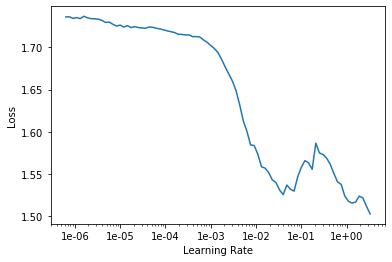

In [73]:
learn.lr_find()
learn.recorder.plot()

In [74]:

learn.fit_one_cycle(1, 1e-2, wd=1e-1, pct_start=0.2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.884298,0.829151,0.687550,39:19


In [76]:
gc.garbage

[]

In [79]:
learn;
gc.collect()

0

In [80]:
gc.collect()

42

In [0]:
# https://medium.com/@wgilliam/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-part-2-9b23ea5d83ee